## Calculate an accuracy value in HSLE Dataset

Data 
    
    - Collected from weight.csv file and applied two columns( weighted_value, IsHS) only. 
    - Manipulated four models(Random-Forest, LogisticRegression,AdaBoostClassifier and KNeighborsClassifier)
    - Selected the best model to predict a label value whether a HS Comment or No HS Comment.
    - Calculated a confusion matrix (Accuracy, Precision,Recall, F1-Score). 


In [1]:
import pandas as pd
import numpy as np
from glob import glob 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import math 
import gspread 
import os 
from oauth2client.service_account import ServiceAccountCredentials


In [ ]:
scope = ["https://spreadsheets.google.com/feeds", 'https://www.googleapis.com/auth/drive']

creds= ServiceAccountCredentials.from_json_keyfile_name('hs_data_sheet.json',scope)
client = gspread.authorize(creds)
HS_Accuracy =client.open('HS_Accuracy')

weighted_value_by_lexicon = HS_Accuracy.get_worksheet(2)   #annotate_here

weighted_value_by_lexicon_val=weighted_value_by_lexicon.get_all_records()
weighted_value_by_lexicon_list=[]
for index in range(len(weighted_value_by_lexicon_val)):
    for key in weighted_value_by_lexicon_val[index]:
        if key=='LexFound':
            LexFound_key=weighted_value_by_lexicon_val[index][key]
        elif key=='MsgUniSeg':
            MsgUniSeg_key=weighted_value_by_lexicon_val[index][key]
        elif key=='NewHSWordInSentence':
            NewHSWordInSentence_key=weighted_value_by_lexicon_val[index][key]
        elif key=='Weighted_Value':
            Weighted_Value_key =weighted_value_by_lexicon_val[index][key]
        elif key=='IsHS':
            IsHS=weighted_value_by_lexicon_val[index][key]
        else:pass
    weighted_value_by_lexicon_list.append([LexFound_key,MsgUniSeg_key,NewHSWordInSentence_key,Weighted_Value_key,IsHS])

#Create annotate_here dataframe 
weighted_val_new = pd.DataFrame(weighted_value_by_lexicon_list, columns=['LexFound','MsgUniSeg','NewHSWordInSentence','Weighted_Value','IsHS'])


In [5]:
# Preprocessing Step
weighted_val_new['Weighted_Value'].isna().sum()

0

In [6]:
X=weighted_val_new[['Weighted_Value']]

In [7]:
 weighted_val_new['IsHS'].unique()

array([1, 0])

In [8]:
# y is a vector, hence we use dot to access 'label'
y = weighted_val_new[['IsHS']]

In [9]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,random_state=1)

In [10]:
## Apply RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
ytrain_pred = rf_model.predict_proba(X_train)
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = (rf_model.predict_proba(X_test))
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

RF train roc-auc: 0.7945313106386851
RF test roc-auc: 0.7494561882900298


In [11]:
log_classifier=LogisticRegression()
log_classifier.fit(X_train, y_train)
ytrain_pred = log_classifier.predict_proba(X_train)
print('Logistic train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = log_classifier.predict_proba(X_test)
print('Logistic test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Logistic train roc-auc: 0.7574889662684978
Logistic test roc-auc: 0.7611308914662572


In [12]:
ada_classifier=AdaBoostClassifier()
ada_classifier.fit(X_train, y_train)
ytrain_pred = ada_classifier.predict_proba(X_train)
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = ada_classifier.predict_proba(X_test)
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Adaboost train roc-auc: 0.7671982217559224
Adaboost test roc-auc: 0.7615558137661795


In [13]:
knn_classifier=KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
ytrain_pred = knn_classifier.predict_proba(X_train)
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = knn_classifier.predict_proba(X_test)
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Adaboost train roc-auc: 0.7201040877666763
Adaboost test roc-auc: 0.6940680846930848


In [14]:
pred=[]
for model in [rf_model,log_classifier,ada_classifier,knn_classifier]:
    pred.append(pd.Series(model.predict_proba(X_test)[:,1]))
final_prediction=pd.concat(pred,axis=1).mean(axis=1)
print(' test roc-auc: {}'.format(roc_auc_score(y_test,final_prediction)))

 test roc-auc: 0.7585043682604659


In [15]:
pd.concat(pred,axis=1).mean(axis=1)

0       0.179836
1       0.478054
2       0.497113
3       0.179836
4       0.528985
          ...   
4641    0.176557
4642    0.143245
4643    0.178529
4644    0.147555
4645    0.395896
Length: 4646, dtype: float64

In [16]:
#### Calculate the ROc Curve
fpr, tpr, thresholds = roc_curve(y_test, final_prediction)
# thresholds

In [17]:
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(accuracy_score(y_test, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()


,thresholds,accuracy
71,0.473019,0.814464
69,0.477196,0.814464
67,0.486476,0.814249
70,0.473198,0.814249
72,0.471382,0.814249


In [18]:
# print the first predicted probabilities of class membership
y_pred_class =(rf_model.predict_proba(X_test)[:,1] >=0.3).astype(bool)

In [19]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)

#[row, column]
TP = confusion[1, 1]  # 455
TN = confusion[0, 0]  # 3080
FP = confusion[0, 1]  # 664
FN = confusion[1, 0]  # 447


[[3167  577]
 [ 477  425]]


In [20]:
# use float to perform true division, not integer division
Accuracy =(TP + TN) / float(TP + TN + FP + FN)

print("Accuracy  :  ",Accuracy)
print("Accuracy  :  ",metrics.accuracy_score(y_test, y_pred_class))

Accuracy  :   0.7731381833835558
Accuracy  :   0.7731381833835558


In [21]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.22686181661644425
0.22686181661644422


In [22]:
sensitivity_recall = TP / float(FN + TP)   # True Positive Rate


print("Recall           : ",sensitivity_recall)

print("Metric Recall    : ",metrics.recall_score(y_test, y_pred_class))

Recall           :  0.47117516629711753
Metric Recall    :  0.47117516629711753


In [23]:
specificity = TN / (TN + FP)  

print(specificity)

0.8458867521367521


In [24]:
false_positive_rate = FP / float(TN + FP)   # False Positive Rate

print(false_positive_rate)
print(1 - specificity)

0.15411324786324787
0.15411324786324787


In [25]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, y_pred_class))

0.4241516966067864
0.4241516966067864


In [26]:
F1=2*((precision*sensitivity_recall)/(precision+sensitivity_recall))


In [27]:
print("Accuracy     :   ",Accuracy)
print("Precision    :   ",precision)
print("Recall       :   ",sensitivity_recall)
print("F1 Score     :   ",F1)

Accuracy     :    0.7731381833835558
Precision    :    0.4241516966067864
Recall       :    0.47117516629711753
F1 Score     :    0.44642857142857145


In [28]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

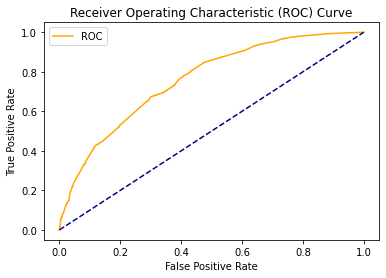

In [29]:
plot_roc_curve(fpr,tpr)